# Objectives
...
# Imports

In [1]:
# Import required libraries
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Tuple
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    demographic_parity_difference,
    demographic_parity_ratio,
    true_positive_rate_difference
)
from sklearn.metrics import mutual_info_score

# User Configuration

In [16]:
# Configuration
SAVE_DATA = True  # Whether to save generated figures and CSVs

# File paths – consider loading these from a config or CLI for flexibility
REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

# Define directories for input and output
DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # Ensure output dir exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # Ensure output dir exists

# Age group bins and labels (should match domain requirements)
AGE_BINS = [-np.inf, 29, 60, np.inf]
AGE_LABELS = ["<30", "30-60", ">60"]

# Define sensitive features for fairness analysis
SENSITIVE_FEATURES = ["gender", "ethnicity", "age_group"]

# Set seaborn style for plots
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

In [3]:
def add_age_group_column(df, col="age", new_col="age_group"):
    """Cut age into three bins."""
    df[new_col] = pd.cut(df[col], bins=AGE_BINS, labels=AGE_LABELS, right=False)

# Data Loading

In [4]:
def load_data(real_filename: str, synth_filename: str, holdout_filename: str | None = None) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame | None]:
    """Read real, synthetic, and optional holdout CSVs into DataFrames."""
    df_real = pd.read_csv(DATA_DIR / real_filename, low_memory=False)
    df_synth = pd.read_csv(DATA_DIR / synth_filename, low_memory=False)
    df_holdout = pd.read_csv(DATA_DIR / holdout_filename, low_memory=False) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Methods

In [5]:
def compute_selection_rate(
    data: pd.DataFrame,
    target: str = "icu_admission_24h",
    sensitive_columns: Tuple[str, ...] = ("gender", "ethnicity", "age_group"),
) -> pd.DataFrame:
    """
    Compute the selection rate for each intersectional subgroup and prepare
    the result for heatmap plotting.

    Args:
        data: A pandas DataFrame containing the outcome and sensitive features.
        target: Name of the binary outcome column in `data`.
        sensitive_columns: Tuple of column names to form intersectional subgroups.

    Returns:
        A DataFrame with one row per subgroup and columns:
          - Subgroup: the joined subgroup key (e.g. "Male_White_30-40")
          - selection_rate: float (rate of positive outcomes)
          - one column per sensitive feature, splitting out the subgroup key.
    """
    # Validate inputs
    missing = set(sensitive_columns + (target,)) - set(data.columns)
    if missing:
        raise KeyError(f"Missing required columns in DataFrame: {missing!r}")

    # Build the subgroup key
    subgroup_key = (
        data[list(sensitive_columns)]
        .astype(str)
        .agg("_".join, axis=1)
        .rename("Subgroup")
    )

    # Ensure target is binary and integer
    y_true = data[target].astype(int)

    # Compute selection rates treating the outcome as a "prediction"
    metric_frame = MetricFrame(
        metrics=selection_rate,
        y_true=y_true,
        y_pred=y_true,
        sensitive_features=subgroup_key,
    )

    # Extract group-level results
    result = (
        metric_frame.by_group
        .rename_axis("Subgroup")
        .reset_index(name="selection_rate")
    )

    # Split Subgroup back into individual sensitive columns
    split_cols = result["Subgroup"].str.split("_", expand=True)
    split_cols.columns = sensitive_columns

    # Combine into final output
    output_df = pd.concat([result, split_cols], axis=1)

    return output_df

import pandas as pd

def selection_rate_delta(df_ref: pd.DataFrame,
                         df_new: pd.DataFrame,
                         group_cols: list,
                         rate_col: str = "selection_rate",
                         suffix_ref: str = "_ref",
                         suffix_new: str = "_new",
                         delta_col: str = None
                        ) -> pd.DataFrame:
    """
    Compute df_new[rate_col] - df_ref[rate_col] for each group in group_cols.

    Parameters
    ----------
    df_ref : pd.DataFrame
        Baseline dataframe.
    df_new : pd.DataFrame
        Comparison dataframe (must have the same groups in group_cols).
    group_cols : list of str
        The columns to merge on (your “true” subgroup keys).
    rate_col : str, default "selection_rate"
        Which column to diff.
    suffix_ref : str, default "_ref"
        Suffix for rate_col in df_ref.
    suffix_new : str, default "_new"
        Suffix for rate_col in df_new.
    delta_col : str, optional
        Name of the output difference column. If None, will be
        f"delta_{rate_col}". 

    Returns
    -------
    pd.DataFrame
        group_cols + [rate_col+suffix_ref, rate_col+suffix_new, delta_col].
    """
    if delta_col is None:
        delta_col = f"delta_{rate_col}"

    # isolate and rename
    left = (
        df_ref[group_cols + [rate_col]]
        .rename(columns={rate_col: rate_col + suffix_ref})
    )
    right = (
        df_new[group_cols + [rate_col]]
        .rename(columns={rate_col: rate_col + suffix_new})
    )

    # merge only on your specified keys
    merged = pd.merge(left, right, on=group_cols, how="inner")

    # compute the difference
    merged[delta_col] = (
        merged[rate_col + suffix_new]
        - merged[rate_col + suffix_ref]
    )

    return merged


def fairness_metrics(
    data: pd.DataFrame,
    target: str = "icu_admission_24h",
    sensitive_columns: Tuple[str, ...] = ("gender", "ethnicity", "age_group"),
    mi_in_bits: bool = True,
) -> dict:
    """
    Compute distribution-level fairness metrics on raw data.
    """
    # Validate inputs
    missing = set(sensitive_columns + (target,)) - set(data.columns)
    if missing:
        raise KeyError(f"Missing required columns in DataFrame: {missing!r}")

    # Build the subgroup key
    subgroup_key = (
        data[list(sensitive_columns)]
        .astype(str)
        .agg("_".join, axis=1)
        .rename("Subgroup")
    )

    y = data[target].astype(int)

    # 3. per-group selection rate
    mf = MetricFrame(                               # <<< ADDED y_pred=y
        metrics=selection_rate,
        y_true=y,
        y_pred=y,                                   # use outcome as pseudo-prediction
        sensitive_features=subgroup_key,
    )
    sr_by_group = mf.by_group

    # 4. aggregated disparities
    dp_diff  = demographic_parity_difference(y_true=y, y_pred=y, sensitive_features=subgroup_key)
    dp_ratio = demographic_parity_ratio    (y_true=y, y_pred=y, sensitive_features=subgroup_key)
    tpr_diff = true_positive_rate_difference(y_true=y, y_pred=y, sensitive_features=subgroup_key)
    worst_case = sr_by_group.max() - sr_by_group.min()

    # 5. mutual information
    mi = mutual_info_score(subgroup_key, y)
    if mi_in_bits:
        mi /= np.log(2)

    return {
        "selection_rate_by_group": sr_by_group,
        "demographic_parity_difference": dp_diff,
        "demographic_parity_ratio": dp_ratio,
        "true_positive_rate_difference": tpr_diff,
        "worst_case_disparity": worst_case,
        "mutual_information_bits" if mi_in_bits else "mutual_information_nats": mi,
    }


# ----------------------------------------------------------------------
# Convenience wrapper to compare real vs. synthetic data
# ----------------------------------------------------------------------
def bias_amplification(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    **kwargs,
) -> pd.DataFrame:
    """
    Calculate bias-amplification Δ = metric_synth − metric_real for
    each scalar fairness metric, and (optionally) the per-group SR deltas.

    Returns
    -------
    DataFrame with metric values for real, synth, and Δ.
    """
    real = fairness_metrics(df_real, **kwargs)
    synth = fairness_metrics(df_synth, **kwargs)

    # Scalars
    metrics = {
        k: {"real": real[k], "synth": synth[k], "Δ": synth[k] - real[k]}
        for k in real.keys()
        if not isinstance(real[k], pd.Series)  # skip SR_by_group here
    }
    out = pd.DataFrame(metrics).T  # prettier format

    return out  # (global metric Δ, per-group SR Δ)

# Plot Method

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple


def plot_selection_rate_heatmap_by_gender(
    df: pd.DataFrame,
    gender_col: str = "gender",
    x_col: str = "ethnicity",
    y_col: str = "age_group",
    value_col: str = "selection_rate",
    cmap: Optional[str] = "viridis",
    diverging: bool = False,
    annot: bool = True,
    fmt: str = ".2f",
    cbar: bool = True,
    height: float = 4,
    width: float = 4,
    aspect: float = 1.2,
    custom_scale: Optional[Tuple[float, float]] = None,
) -> plt.Figure:
    """
    Plot selection‐rate heatmaps faceted by gender.

    This expects `df` to have one row per subgroup with columns:
      - gender_col  (e.g. "Male", "Female", ...)
      - x_col       (e.g. ethnicity categories)
      - y_col       (e.g. age_group categories)
      - value_col   (the numeric selection_rate)

    Args:
        df: DataFrame with intersectional subgroup metrics.
        gender_col: column name to facet on (one heatmap per unique value).
        x_col: column to use for heatmap’s x-axis (columns of the matrix).
        y_col: column to use for heatmap’s y-axis (rows of the matrix).
        value_col: the cell value to plot (heat intensity).
        cmap: matplotlib colormap name.
        annot: whether to annotate cells with their values.
        fmt: format string for annotations.
        cbar: whether each facet gets its own colorbar.
        height: height (in inches) of each facet.
        aspect: aspect ratio (width/height) of each facet.

    Returns:
        The Seaborn FacetGrid instance (so you can further tweak or save it).
    """
    # Ensure required columns are present
    missing = {gender_col, x_col, y_col, value_col} - set(df.columns)
    if missing:
        raise KeyError(f"Missing columns in DataFrame: {missing!r}")

    # compute common color‐scale limits
    raw_min = df[value_col].min()
    raw_max = df[value_col].max()
    if custom_scale is not None:
        vmin, vmax = custom_scale
    else:
        if diverging:
            abs_max = max(abs(raw_min), abs(raw_max))
            vmin, vmax = -abs_max, +abs_max
        else:
            vmin, vmax = raw_min, raw_max


    # Create the FacetGrid: one facet per gender
    grid = sns.FacetGrid(
        df,
        col=gender_col,
        sharex=True,
        sharey=True,
        aspect=aspect,
        col_wrap=1,
    )

    # Define the per‐facet heatmap function
    def _draw_heatmap(data: pd.DataFrame, **kwargs):
        # Pivot to matrix form
        pivot = data.pivot(index=y_col, columns=x_col, values=value_col).reindex(AGE_LABELS)
        sns.heatmap(
            pivot,
            annot=annot,
            fmt=fmt,
            cbar=cbar,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            center=0 if diverging else None,
            **kwargs,
        )

    # Map it onto the grid
    grid.map_dataframe(_draw_heatmap)

    # Label axes
    grid.set_axis_labels(x_col, y_col)

    # current_w, current_h = grid.figure.get_size_inches()
    grid.figure.set_size_inches(width, height)
    # Tight layout for nicer spacing
    plt.tight_layout()

    return grid.figure


In [7]:
def plot_grouped_bar_chart(df, 
                     figsize=(8, 5), title='Fairness Metrics') -> plt.Figure:

    # Dataframe in Long-Format bringen
    df_long = df.melt(id_vars='Metric', var_name='Type', value_name='Value')

    # Plot erstellen
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(data=df_long, x='Metric', y='Value', hue='Type', ax=ax)
    # sns.barplot(data=df_long, y='Metric', x='Value', hue='Type', ax=ax, orient='h')
    
    # Y-Achsen-Limit anpassen, z.B. +10% des aktuellen Maximums
    ymax = df_long['Value'].max()
    ax.set_ylim(0, ymax * 1.15)
    # xmax = df_long['Value'].max()
    # ax.set_xlim(0, xmax * 1.15)

    ax.set_title(title)
    ax.set_ylabel('Value')
    ax.set_xlabel('Metric')
    # ax.set_xlabel('Value')
    # ax.set_ylabel('Metric')
    plt.xticks(rotation=45, ha='right')

    label_map = {
        "demographic_parity_difference": "DP Diff",
        "demographic_parity_ratio":      "DP Ratio",
        "worst_case_disparity":          "Worst Disp.",
        "mutual_information_bits":       "MI (bits)",
    }

    locs = ax.get_xticks()  # aktuelle Tick-Positionen auslesen
    raw_labels = [l.get_text() for l in ax.get_xticklabels()]
    new_labels = [label_map.get(lbl, lbl) for lbl in raw_labels]
    ax.set_xticks(locs)  # FixedLocator setzen
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

    # ax.set_xticklabels([label_map.get(l.get_text(), l.get_text()) for l in ax.get_xticklabels()])


    # Add value labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=6)

    ax.legend(loc='upper right', fontsize=6)
    plt.tight_layout()
    return fig

# Main Execution

In [8]:

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
df_real, df_synth, df_holdout = load_data(REAL_FILE, SYNTH_FILE, HOLDOUT_FILE)

for df in [df_real, df_synth, df_holdout]:
    add_age_group_column(df)


# Fig. A: Wie ist der reale Status quo? ICU-Raten pro Subgruppe (aus df_holdout). Heatmaps getrennt nach F und M.
sr_holdout = compute_selection_rate(df_holdout)
# print(sr_holdout.head())

# Fib. B: Wurde Bias durch das CTGAN verstärkt? Δ-Δ Heatmaps (sel_synth - sel_holdout) - (sel_real - sel_holdout), wieder getrennt nach Gender (Amplifikations-Darstellung). sel = Selection rate.
sr_real = compute_selection_rate(df_real)
sr_synth = compute_selection_rate(df_synth)


delta_s_h = selection_rate_delta(
    df_ref=sr_holdout,
    df_new=sr_synth,
    group_cols=SENSITIVE_FEATURES,
    rate_col="selection_rate",      # default
    suffix_ref="_hld",
    suffix_new="_synth",
    delta_col="delta_sr"
)

# print(delta_s_h.head())

delta_r_h = selection_rate_delta(
    df_ref=sr_holdout,
    df_new=sr_real,
    group_cols=SENSITIVE_FEATURES,
    suffix_ref="_hld",
    suffix_new="_real",
    delta_col="delta_sr"
)

# print(delta_r_h.head())

# second-level delta: (synth − holdout) − (real − holdout)
delta_of_deltas = selection_rate_delta(
    df_ref=delta_r_h,
    df_new=delta_s_h,
    group_cols=SENSITIVE_FEATURES,
    rate_col="delta_sr",   # note: the column in df_new
    suffix_ref="_r-h",
    suffix_new="_s-h",
    delta_col="delta_of_deltas"
)

# print(delta_of_deltas.head())


if SAVE_DATA:
    delta_of_deltas.to_csv(OUTPUT_DIR_CSV / f"delta_of_deltas_{ts}.csv", index=False, sep=";", decimal=",", encoding="utf-8")

# # Compute metrics and amplifications
global_metrics = bias_amplification(df_real, df_synth)

# # Display nicely (Jupyter will render as HTML)
display(global_metrics.style.format("{:.4f}"))
df_fig = global_metrics.reset_index().rename(columns={'index': 'Metric'})
df_fig.drop(columns=['Δ'], inplace=True)
df_fig = df_fig[df_fig['Metric'] != 'true_positive_rate_difference']

if SAVE_DATA:
    global_metrics.to_csv(OUTPUT_DIR_CSV / f"global_metrics_{ts}.csv", index=False, sep=";", decimal=",", encoding="utf-8")

,real,synth,Δ
demographic_parity_difference,0.3682,0.2047,-0.1635
demographic_parity_ratio,0.1497,0.0304,-0.1193
true_positive_rate_difference,0.0000,0.0000,0.0000
worst_case_disparity,0.3682,0.2047,-0.1635
mutual_information_bits,0.0064,0.0187,0.0123


## ..-

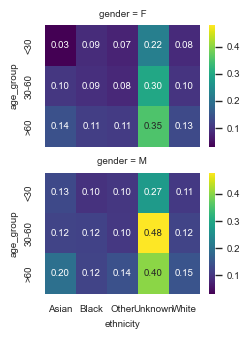

In [9]:
fig = plot_selection_rate_heatmap_by_gender(sr_holdout, width = 2.5, height= 3.4) 
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"selection-rate_heatmap_holdout_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)


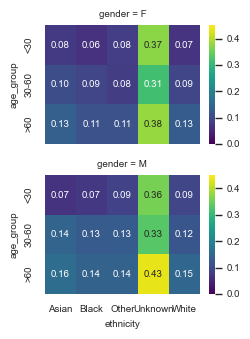

In [17]:
fig = plot_selection_rate_heatmap_by_gender(sr_real, width = 2.5, height= 3.4, custom_scale=(0, 0.45))
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"selection-rate_heatmap_real_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)


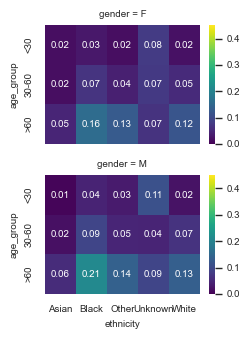

In [18]:
fig = plot_selection_rate_heatmap_by_gender(sr_synth, width = 2.5, height= 3.4, custom_scale=(0, 0.45)) 
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"selection-rate_heatmap_synth_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)


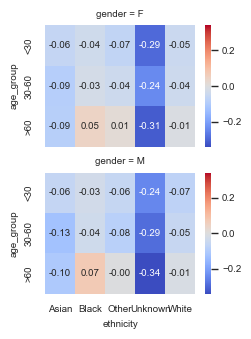

In [12]:

fig = plot_selection_rate_heatmap_by_gender(delta_of_deltas, value_col="delta_of_deltas", cmap="coolwarm", diverging=True, width = 2.5, height= 3.4) 
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"delta-delta-heatmap_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    
plt.close(fig)

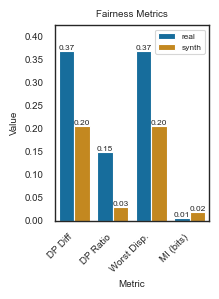

In [65]:

fig = plot_grouped_bar_chart(df_fig, figsize=(2.2, 3))
plt.show()
if SAVE_DATA:
    fig.savefig(OUTPUT_DIR_FIG / f"metrics_datalevel_{ts}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

In [50]:
display(df_fig)

,Metric,real,synth
0,demographic_parity_difference,0.368210,0.204667
1,demographic_parity_ratio,0.149701,0.030369
3,worst_case_disparity,0.368210,0.204667
4,mutual_information_bits,0.006426,0.018679
